In [ ]:
# %% Cell 1: Imports y parseo de argumentos
import os, sys, time
import numba; from numba import njit, prange
import numpy as np
from tqdm import tqdm
import argparse
import tables

def parse_args():
    parser = argparse.ArgumentParser("Ising MC")
    parser.add_argument("-N", type=int, default=250)
    parser.add_argument("-T", type=float, default=1.0)
    parser.add_argument("-J", type=float, default=1.0)
    parser.add_argument("--steps",  type=int,   default=100, dest="MC_STEPS")
    parser.add_argument("--save-interval", type=int, default=1, dest="SAVE_INTERVAL")
    parser.add_argument("--seed", type=int, default=42)
    return parser.parse_args(args=[])

args = parse_args()


In [30]:
# %% Cell 2: Parámetros y semilla
N, T, J = args.N, args.T, args.J
MC_STEPS, SAVE_INTERVAL, SEED = args.MC_STEPS, args.SAVE_INTERVAL, args.seed

# Hilos y semilla
n_threads = max(1, int(os.cpu_count()*0.8))
numba.set_num_threads(n_threads)
print(f"Threads: {n_threads}/{os.cpu_count()}, seed={SEED}")

np.random.seed(SEED)


Threads: 12/16, seed=42


In [31]:
# %% Cell 3: Funciones de flip‐probs y mc_sweep (paralelizado)
energy_changes = np.array([-8, -4, 0, 4, 8], np.int8)

def compute_flip_probs(T):
    return np.exp(-energy_changes.astype(np.float64) / T)

@njit(parallel=True, fastmath=True)
def mc_sweep(spins, N, w, rand_mat):
    accepted_per_i = np.zeros(N, np.int64)
    for i in prange(N):
        acc_i = 0
        for j in range(N):
            vecinos = (
                spins[(i + 1) % N, j] + spins[(i - 1) % N, j] +
                spins[i, (j + 1) % N] + spins[i, (j - 1) % N]
            )
            delta_E = 2 * spins[i, j] * vecinos
            idx     = delta_E // 4 + 2
            if delta_E <= 0 or rand_mat[i, j] < w[idx]:
                spins[i, j] = -spins[i, j]
                acc_i += 1
        accepted_per_i[i] = acc_i
    return spins, accepted_per_i.sum()


In [36]:
# %% Cell 4: Simulación principal con checkpointing
# Inicialización
spins = np.random.choice(np.int8([-1, 1]), size=(N, N))
w     = compute_flip_probs(T)

# Prueba de compilación
_ = mc_sweep(spins.copy(), N, w, np.random.rand(N, N))[0]

# Arrays
magnetizations   = np.zeros(MC_STEPS)
energies         = np.zeros(MC_STEPS)
acceptance_rates = np.zeros(MC_STEPS)
snapshots        = []

for step in tqdm(range(MC_STEPS), desc="MC sweeps"):
    rnd = np.random.rand(N, N)
    spins, acc = mc_sweep(spins, N, w, rnd)
    acceptance_rates[step] = acc / (N * N)
    magnetizations[step]   = compute_magnetization(spins, N)
    energies[step]         = compute_energy(spins, N, J)

    if step % SAVE_INTERVAL == 0:
        snapshots.append(spins.copy())

        # == Checkpointing ==
        np.savez_compressed(
            "ising_checkpoint.npz",
            step=step,
            spins=spins,
            magnetization=magnetizations[: step + 1],
            energy=energies[: step + 1],
            acceptance=acceptance_rates[: step + 1],
            snapshots=np.array(snapshots, dtype=np.int8)
        )


MC sweeps: 100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


In [37]:
# %% Cell 5: Post-procesado, DataFrame y guardado (sin HDF5)
import pandas as pd

# Cálculo de calor y susceptibilidad
mean_E, mean_E2    = energies.mean(), (energies**2).mean()
heat_capacity     = (mean_E2 - mean_E**2) / (T**2 * N**2)
mean_m, mean_m2    = magnetizations.mean(), (magnetizations**2).mean()
susceptibility    = N**2 * (mean_m2 - mean_m**2) / T

# Autocorrelación y τ_int
mag      = magnetizations - mean_m
acf_full = np.correlate(mag, mag, mode='full')
acf      = acf_full[MC_STEPS - 1:] / acf_full[MC_STEPS - 1]
tau_int  = 1 + 2 * np.sum(acf[1:])

# Crear DataFrame de métricas por paso
df = pd.DataFrame({
    'step': np.arange(MC_STEPS),
    'magnetization': magnetizations,
    'energy': energies,
    'acceptance': acceptance_rates
})
# Exportar métricas
df.to_csv('ising_metrics.csv', index=False)
df.to_pickle('ising_metrics.pkl')

# Guardado de snapshots y métricas finales
snap_arr = np.array(snapshots, dtype=np.int8)
np.savez_compressed(
    "ising_data.npz",
    snapshots=snap_arr,
    magnetization=magnetizations,
    energy=energies,
    acceptance=acceptance_rates,
    heat_capacity=heat_capacity,
    susceptibility=susceptibility,
    autocorrelation=acf,
    tau_int=tau_int
)

# Resumen final
elapsed = time.time() - start_time
h, rem = divmod(elapsed, 3600)
m, s   = divmod(rem, 60)
print(
    f"Simulación completada en {int(h):02d}:{int(m):02d}:{int(s):02d}\n"
    f"Heat capacity per spin:  {heat_capacity:.6f}\n"
    f"Susceptibility:          {susceptibility:.6f}\n"
    f"Integrated corr. time τ: {tau_int:.2f} pasos"
)


Simulación completada en 00:18:14
Heat capacity per spin:  1354.794589
Susceptibility:          779.317990
Integrated corr. time τ: 0.00 pasos


Usando 12 threads de 16 disponibles
Leyendo datos y preparando frames…
Datos preparados en 00:00:00 (hh:mm:ss)
Instanciando FuncAnimation (compilación)…
Animación lista en 00:00:00 (hh:mm:ss)
Guardando animación en 'ising.mp4'…
Frame 100/100 (100.0%)  Elapsed 00:00:11  ETA 00:00:00
Guardado completado en 00:00:12 (hh:mm:ss)


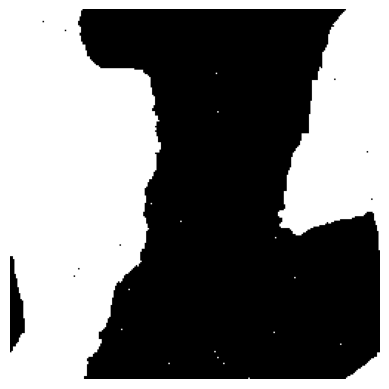

In [38]:
# %% Cell 6: Animación de los resultados

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
import io

# ========================================================================
# Parámetros
file_in      = "ising_data.dat"
file_out     = "ising"
interval     = 50     # ms entre fotogramas
save_to_file = True
dpi          = 400

# ------------------------------------------------------------------------
# Control de threads (~80% CPU)
n_threads = max(1, int(os.cpu_count() * 0.8))
print(f"Usando {n_threads} threads de {os.cpu_count()} disponibles")

# ------------------------------------------------------------------------
# 1) Lectura de datos y preparación de frames
print("Leyendo datos y preparando frames…")
t0 = time.time()
frames_data = []
with open(file_in, "r") as f:
    data_str = f.read()
for block in data_str.split("\n\n"):
    b = block.strip()
    if not b:
        continue
    frames_data.append(np.loadtxt(io.StringIO(b), delimiter=","))
tiempo_lectura = time.time() - t0
h, rem = divmod(tiempo_lectura, 3600)
m, s   = divmod(rem, 60)
print(f"Datos preparados en {int(h):02d}:{int(m):02d}:{int(s):02d} (hh:mm:ss)")

# ------------------------------------------------------------------------
# Preparación de la figura
fig, ax = plt.subplots()
ax.axis("off")
im = ax.imshow(frames_data[0], cmap="binary", vmin=-1, vmax=+1)

def update(j, frames_data, im):
    im.set_data(frames_data[j])
    return (im,)

nframes = len(frames_data)

# ------------------------------------------------------------------------
if nframes > 1:
    # 2) Compilación de la animación
    print("Instanciando FuncAnimation (compilación)…")
    t0 = time.time()
    animation = FuncAnimation(
        fig, update, fargs=(frames_data, im),
        frames=nframes, blit=True, interval=interval
    )
    tiempo_compil = time.time() - t0
    h, rem = divmod(tiempo_compil, 3600)
    m, s   = divmod(rem, 60)
    print(f"Animación lista en {int(h):02d}:{int(m):02d}:{int(s):02d} (hh:mm:ss)")

    # 3) Guardado de vídeo con barra de progreso
    if save_to_file:
        fps = 1000 / interval
        writer = FFMpegWriter(
            fps=fps,
            codec="libx264",
            bitrate=2000,
            extra_args=[
                "-threads", str(n_threads),
                "-preset", "medium",
                "-crf", "18",
                "-pix_fmt", "yuv420p"
            ]
        )
        print(f"Guardando animación en '{file_out}.mp4'…")
        start_time = time.time()
        with writer.saving(fig, f"{file_out}.mp4", dpi=dpi):
            for i in range(nframes):
                # renderiza y escribe frame
                update(i, frames_data, im)
                writer.grab_frame()

                # cálculo de progreso y ETA
                elapsed = time.time() - start_time
                frac    = (i + 1) / nframes
                eta     = elapsed * (1 - frac) / frac if frac > 0 else 0
                h_e, rem_e     = divmod(elapsed, 3600)
                m_e, s_e       = divmod(rem_e, 60)
                h_eta, rem_eta = divmod(eta, 3600)
                m_eta, s_eta   = divmod(rem_eta, 60)
                print(
                    f"\rFrame {i+1}/{nframes} "
                    f"({frac*100:5.1f}%)  "
                    f"Elapsed {int(h_e):02d}:{int(m_e):02d}:{int(s_e):02d}  "
                    f"ETA {int(h_eta):02d}:{int(m_eta):02d}:{int(s_eta):02d}",
                    end="", flush=True
                )
        total_time = time.time() - start_time
        h_t, rem_t = divmod(total_time, 3600)
        m_t, s_t   = divmod(rem_t, 60)
        print()  # salto de línea tras la barra
        print(f"Guardado completado en {int(h_t):02d}:{int(m_t):02d}:{int(s_t):02d} (hh:mm:ss)")
    else:
        plt.show()

else:
    # Solo un frame: guardar imagen estática
    print("Un único frame: guardando PDF…")
    start_time = time.time()
    fig.savefig(f"{file_out}.pdf", dpi=dpi)
    total_time = time.time() - start_time
    h, rem = divmod(total_time, 3600)
    m, s   = divmod(rem, 60)
    print(f"Imagen guardada en {int(h):02d}:{int(m):02d}:{int(s):02d} (hh:mm:ss)")
